<a href="https://colab.research.google.com/github/shahabday/DSR-LLM-finetuning/blob/main/03_1_Fine_Tune_Pig_Latin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install accelerate datasets peft trl bitsandbytes matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Harvard Sentences

Conditions of use: The material on this site is freely available for use in VoIP testing, research, development, marketing and any other reasonable application. The material may be copied, downloaded, broadcast, modified, incorporated into web sites or test equipment. We do require that you identify the source of the speech materials as "Open Speech Repository"..

https://www.cs.columbia.edu/~hgs/audio/harvard.html

## Pig Latin

In [ ]:
import re
from string import punctuation

def pig_latin(sentence):
    toks = [t.lower() for t in re.findall(r'\w+|[^\s\w]+', sentence) if len(t) > 0]

    def convert(string):
        # if starts with a vowel, just add "ay"
        # else move the consonants to the end and add "ay"
        if string in punctuation:
            return string
        elif string[0].lower() in {'a', 'e', 'i', 'o', 'u'}:
            return ' ' + string + 'way'
        else:
            beginning_consonants = []
            for i in range(len(string)):
                if string[i].lower() in {'a', 'e', 'i', 'o', 'u'}:
                    break
                beginning_consonants.append(string[i])
            return ' ' + string[i:] + ''.join(beginning_consonants) + 'ay'

    return ''.join([convert(t) for t in toks]).strip()

In [ ]:
pig_latin('How are you doing today?')

'owhay areway ouyay oingday odaytay?'

### Load Harvard Sentences

In [ ]:
!gdown 1pg8hJEdhiHjfcrvo3XzuW4d80xzqnFsl

Downloading...
From: https://drive.google.com/uc?id=1pg8hJEdhiHjfcrvo3XzuW4d80xzqnFsl
To: /content/harvard_sentences.txt
100% 30.5k/30.5k [00:00<00:00, 85.7MB/s]


In [ ]:
from datasets import load_dataset, Split
dataset = load_dataset(path='csv', data_files='harvard_sentences.txt', quotechar='"', split=Split.ALL)
dataset = dataset.shuffle().train_test_split(test_size=0.2)

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence'],
        num_rows: 576
    })
    test: Dataset({
        features: ['sentence'],
        num_rows: 144
    })
})

In [ ]:
dataset['train'][0]

{'sentence': 'The good book informs of what we ought to know.'}

### Translate Sentences to Pig Latin

In [ ]:
pig_ds = dataset.map(lambda s: {'translated': pig_latin(s['sentence'])})

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

In [ ]:
pig_ds['train'][1]

{'sentence': 'The stray cat gave birth to kittens.',
 'translated': 'ethay aystray atcay avegay irthbay otay ittenskay.'}

### Prompt Dataset

In [ ]:
prompt_pig = pig_ds.rename_columns({'sentence': 'prompt', 'translated': 'completion'}).select_columns(['prompt', 'completion'])

In [ ]:
prompt_pig['train'][0]

{'prompt': 'The good book informs of what we ought to know.',
 'completion': 'ethay oodgay ookbay informsway ofway atwhay eway oughtway otay owknay.'}

## Tokenizer

In [ ]:
from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader
from trl import DataCollatorForCompletionOnlyLM

base_model_id = 'microsoft/phi-2'

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
)
tokenizer.add_special_tokens({'pad_token': '<|pad|>'})
tokenizer.padding_side = 'left'

In [ ]:
response_template = '##[PIGL]##>'
tokenizer.add_special_tokens({'additional_special_tokens': [response_template]})

len(tokenizer)

50297

In [ ]:
tokenizer.pad_token, tokenizer.eos_token, tokenizer.bos_token, tokenizer.unk_token

('<|pad|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>')

In [ ]:
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

### Formatting

Let's build a formatting function that takes both prompt and completion, and inserts a particular string that will be used to trigger the translation. This string is the response template.

In [ ]:
def formatting_func(example):
    return f'{example["prompt"]}{response_template}{example["completion"]}' + tokenizer.eos_token

formatting_func(prompt_pig['train'][1])

NameError: name 'prompt_pig' is not defined

In [ ]:
def generate_and_tokenize_prompt(prompt, max_length=128, padding=True):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length" if padding else False,
    )
    result["labels"] = result["input_ids"].copy()
    return result

dataset = prompt_pig['train'].map(lambda v: generate_and_tokenize_prompt(v, padding=False))
dataset = dataset.remove_columns(['prompt', 'completion'])
print(dataset[0])

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

{'input_ids': [1026, 373, 257, 2089, 4049, 319, 262, 636, 286, 262, 649, 5052, 13, 50296, 270, 1014, 355, 1014, 1497, 512, 24406, 4049, 1014, 319, 1014, 4555, 323, 1242, 15577, 286, 1014, 4555, 323, 304, 675, 323, 334, 67, 469, 33708, 13, 50256], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [1026, 373, 257, 2089, 4049, 319, 262, 636, 286, 262, 649, 5052, 13, 50296, 270, 1014, 355, 1014, 1497, 512, 24406, 4049, 1014, 319, 1014, 4555, 323, 1242, 15577, 286, 1014, 4555, 323, 304, 675, 323, 334, 67, 469, 33708, 13, 50256]}


576


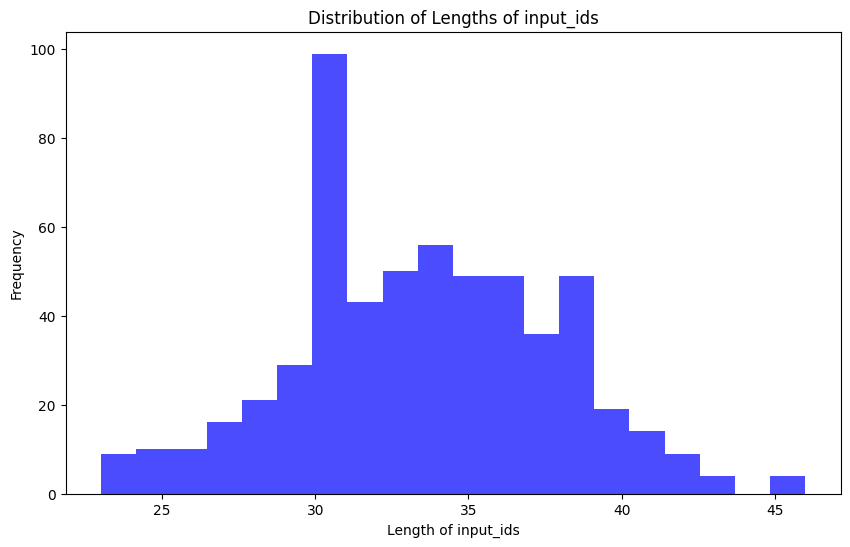

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(dataset)

In [ ]:
max_length = 64
tokenized_train_dataset = prompt_pig['train'].map(lambda v: generate_and_tokenize_prompt(v, max_length))
tokenized_val_dataset = prompt_pig['test'].map(lambda v: generate_and_tokenize_prompt(v, max_length))

Map:   0%|          | 0/576 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

In [ ]:
tokenizer.decode(tokenized_train_dataset[1]['input_ids'])

'<|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|><|pad|>The swan dive was far short of perfect.##[PIGL]##>ethay answay iveday asway arfay ortshay ofway erfectpay.<|endoftext|>'

## Model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, quantization_config=bnb_config)
# no need
# model.resize_token_embeddings(len(tokenizer))

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model.model.embed_tokens, len(tokenizer)

(Embedding(51200, 2560), 50297)

In [ ]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
          (dense): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear8bitLt(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear8bitLt(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (rotary_emb): PhiRotaryEmbedding()
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (final_

In [ ]:
def print_trainable_parameters(model, verbose=False):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for name, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            if verbose:
                print(name)
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
print_trainable_parameters(model, verbose=True)

model.embed_tokens.weight
model.layers.0.input_layernorm.weight
model.layers.0.input_layernorm.bias
model.layers.1.input_layernorm.weight
model.layers.1.input_layernorm.bias
model.layers.2.input_layernorm.weight
model.layers.2.input_layernorm.bias
model.layers.3.input_layernorm.weight
model.layers.3.input_layernorm.bias
model.layers.4.input_layernorm.weight
model.layers.4.input_layernorm.bias
model.layers.5.input_layernorm.weight
model.layers.5.input_layernorm.bias
model.layers.6.input_layernorm.weight
model.layers.6.input_layernorm.bias
model.layers.7.input_layernorm.weight
model.layers.7.input_layernorm.bias
model.layers.8.input_layernorm.weight
model.layers.8.input_layernorm.bias
model.layers.9.input_layernorm.weight
model.layers.9.input_layernorm.bias
model.layers.10.input_layernorm.weight
model.layers.10.input_layernorm.bias
model.layers.11.input_layernorm.weight
model.layers.11.input_layernorm.bias
model.layers.12.input_layernorm.weight
model.layers.12.input_layernorm.bias
model.

### LoRA

In [ ]:
from peft import prepare_model_for_kbit_training

model = prepare_model_for_kbit_training(model)

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "dense"
        "fc1", "fc2",
        "lm_head",
    ],
    modules_to_save=['layernorm', 'embed_tokens'],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 146,519,040 || all params: 2,926,202,880 || trainable%: 5.0071


In [ ]:
print_trainable_parameters(peft_model, verbose=True)

base_model.model.model.embed_tokens.modules_to_save.default.weight
base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.k_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.k_proj.lora_B.default.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight
base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight
base_model.model.model.layers.0.mlp.fc2.lora_A.default.weight
base_model.model.model.layers.0.mlp.fc2.lora_B.default.weight
base_model.model.model.layers.0.input_layernorm.modules_to_save.default.weight
base_model.model.model.layers.0.input_layernorm.modules_to_save.default.bias
base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight
base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight
base_model.model.model.layers.1.self_attn.k_proj.lora_A.default.weight
base_model.mod

In [ ]:
# Some Environment Setup
OUTPUT_DIR = "./results/pigl" # the path to the output directory; where model checkpoints will be saved

In [ ]:
import transformers

training_args = transformers.TrainingArguments(
        output_dir=OUTPUT_DIR,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        auto_find_batch_size=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        optim="paged_adamw_8bit",
        logging_steps=25,            # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=500,                # Save checkpoints every 50 steps
        eval_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="none",
)

In [ ]:
trainer = transformers.Trainer(
    model=peft_model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=training_args,
    data_collator=collator
)

trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/autograd/_functions.py:315: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss
25,5.396200,4.043763
50,3.495300,2.684367
75,2.740200,2.197930


KeyboardInterrupt: 

In [ ]:
OUTPUT_DIR

'./results/pigl'

In [ ]:
OUTPUT_DIR = "./results/pigl" # the path to the output directory; where model checkpoints will be saved
model_ckpt = OUTPUT_DIR + "/stop"

#trainer.save_model(model_ckpt)

## Reloading the Model

In [ ]:
# Downloads and unzips trained adapter
!gdown 1Zwyu3uPC0v-oQHNmT1HidBsjfk2MRTi5
!unzip piglatin_adapter.zip -d ./

Archive:  piglatin_adapter.zip
  inflating: ./results/pigl/stop/adapter_config.json  
  inflating: ./results/pigl/stop/adapter_model.safetensors  
  inflating: ./results/pigl/stop/README.md  
  inflating: ./results/pigl/stop/training_args.bin  


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, trust_remote_code=True, quantization_config=bnb_config, device_map='cuda:0')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from peft import PeftModel

OUTPUT_DIR = "./results/pigl" # the path to the output directory; where model checkpoints will be saved
model_ckpt = OUTPUT_DIR + "/stop"

fine_tuned_model = PeftModel.from_pretrained(model, model_ckpt)

In [ ]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): ModulesToSaveWrapper(
          (original_module): Embedding(51200, 2560)
          (modules_to_save): ModuleDict(
            (default): Embedding(51200, 2560)
          )
        )
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=2560, out_features=2560, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2560, bias=False)
                )
                (lora_embedding_A): ParameterDi

In [ ]:
eval_prompt = "Luke, I am your father!"
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

fine_tuned_model.eval()
with torch.no_grad():
    output = fine_tuned_model.generate(**model_input,
                                       max_new_tokens=100,
                                       repetition_penalty=1.1)[0]
    print(tokenizer.decode(output, skip_special_tokens=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Luke, I am your father!##[PIGL]##>ukelyay,way imay aymay urfray!<|endoftext|>


In [ ]:
eval_prompt = "How are you?"
response_template = '##[PIGL]##>'
model_input = tokenizer(eval_prompt+response_template, return_tensors="pt").to("cuda")

fine_tuned_model.eval()
with torch.no_grad():
    print(tokenizer.decode(fine_tuned_model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.1)[0], skip_special_tokens=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


How are you?##[PIGL]##>ehay areway ouyay?<|endoftext|>


In [ ]:
def generate(model, tokenizer, prompt, response_template="", max_new_tokens=100):
    tokenized_input = tokenizer(prompt+response_template, return_tensors="pt")
    input_ids = tokenized_input["input_ids"].cuda()

    model.eval()
    generation_output = model.generate(
        input_ids=input_ids,
        max_new_tokens=max_new_tokens,
        repetition_penalty=1.1
    )
    seq = generation_output[0]
    output = tokenizer.decode(seq, skip_special_tokens=False)
    return output.strip()

In [ ]:
max_length = 64
generate(fine_tuned_model, tokenizer, 'how are you doing?', response_template, max_length)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


'how are you doing?##[PIGL]##>owhay away ouyay oingday?<|endoftext|>'

In [ ]:
sample = prompt_pig['train'][7]
generate(fine_tuned_model, tokenizer, sample['prompt'], response_template, max_length)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Thick glasses helped him read the print.##[PIGL]##>ickthay azzglssay ephledhay imedray ethay intpray.<|endoftext|>'

In [ ]:
with fine_tuned_model.disable_adapter():
    print(generate(fine_tuned_model, tokenizer, sample['prompt']))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Thick glasses helped him read the print.
<|endoftext|>


In [ ]:
with fine_tuned_model.disable_adapter():
    print(generate(fine_tuned_model, tokenizer, sample['prompt'], response_template))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Thick glasses helped him read the print.##[PIGL]##>, and he was able to enjoy his book without any further issues.

Q&A:
1. Why did John have trouble reading his book? 
Answer: John had trouble reading his book because of his poor eyesight.
2. What did Sarah suggest to help John see better? 
Answer: Sarah suggested that John try wearing thick glasses.
3. Did John take Sarah's advice? 
Answer: Yes, John took Sarah's advice and bought a pair
